# **Generate Realistic Human Face using GAN**

In [ ]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import os

from tqdm import tqdm
from PIL import Image as Img
from IPython.display import Image
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

## **Load the data and resize the iamges**

In [ ]:
from PIL import Image # Import the Image module from PIL

In [ ]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

def load_data(pic_folder, images_count, width, height, normalize=True):
    """
    Loads, resizes, and optionally normalizes images from a directory.
    Returns:
           numpy.ndarray: A NumPy array representing the resized (and optionally normalized) images.
    """

    images = []
    for pic_file in tqdm(os.listdir(pic_folder)[:images_count]):
        pic = Image.open(os.path.join(pic_folder, pic_file)) # Open the image file.
        pic.thumbnail((width, height), Image.ANTIALIAS) # Resize the image using antialiasing
        images.append(np.array(pic))  # Append as numpy array directly.

    images = np.array(images) # convert list to numpy array.

    if normalize:
        images = images / 255.0  # Normalize to [0, 1] if requested.

    return images

In [ ]:
# Execute the function:
pic_folder = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256/'
images_count = 30000
WIDTH = 128
HEIGHT = 128

images = load_data(pic_folder, images_count, WIDTH, HEIGHT)

100%|██████████| 30000/30000 [05:44<00:00, 87.02it/s]


### **Display first 36 images**

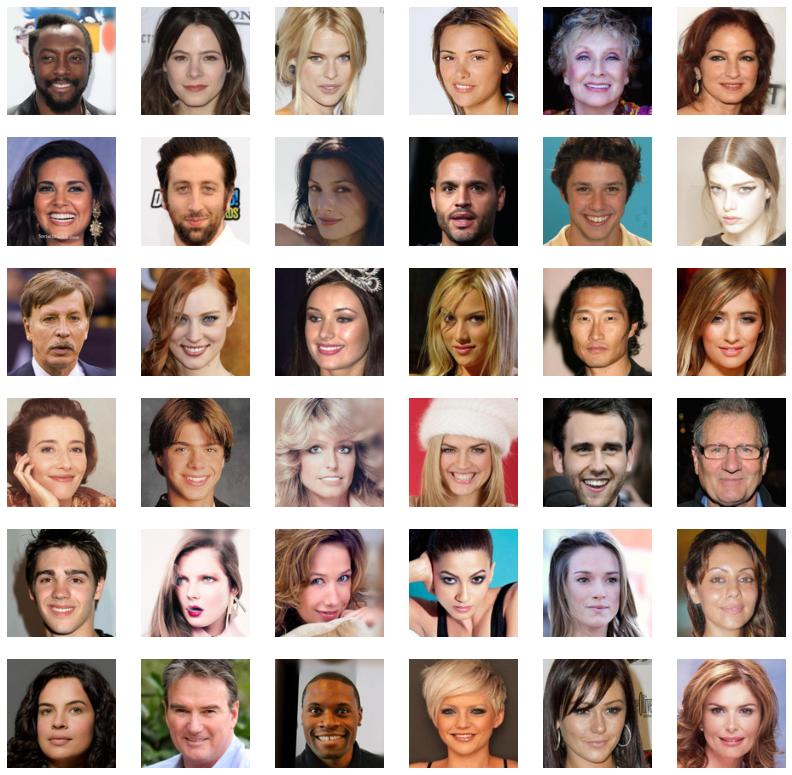

In [ ]:
#Display first 25 images
plt.figure(1, figsize=(14, 14))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

## **Model Building**

### **Create Discriminator**

The discriminator network consists of convolutional layers the same as the generator. For every layer of the network, we are going to perform a convolution, then we are going to perform batch normalization to make the network faster and more accurate and finally, we are going to perform a Leaky ReLu.

In [ ]:
channels = 3  # Define the number of channels in the input image (3 for RGB)

def create_discriminator():
    """
    Creates the discriminator model for the GAN.
    """
    disc_input = Input(shape=(HEIGHT, WIDTH, channels))  # Define the input layer for the discriminator, which takes an image as input

    x = Conv2D(256, 3)(disc_input)  # First convolutional layer for feature extraction
    x = LeakyReLU()(x)  # Apply LeakyReLU activation for non-linearity

    x = Conv2D(256, 4, strides=2)(x)  # Second convolutional layer with stride 2 for downsampling
    x = LeakyReLU()(x)  # Apply LeakyReLU activation

    x = Conv2D(256, 4, strides=2)(x)  # Third convolutional layer with stride 2 for downsampling
    x = LeakyReLU()(x)  # Apply LeakyReLU activation

    x = Conv2D(256, 4, strides=2)(x)  # Fourth convolutional layer with stride 2 for downsampling
    x = LeakyReLU()(x)  # Apply LeakyReLU activation

    x = Conv2D(256, 4, strides=2)(x)  # Fifth convolutional layer with stride 2 for downsampling
    x = LeakyReLU()(x)  # Apply LeakyReLU activation

    x = Flatten()(x)  # Flatten the output to a 1D vector
    x = Dropout(0.4)(x)  # Apply dropout to reduce overfitting

    x = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid activation for binary classification (real or fake)
    discriminator = Model(disc_input, x)  # Create the discriminator model using the input and output tensors

    optimizer = RMSprop(  # Initialize the RMSprop optimizer
        lr=.0001,  # Set the learning rate
        clipvalue=1.0,  # Set the clipvalue to prevent exploding gradients
        decay=1e-8  # Set the decay rate for learning rate decay
    )

    discriminator.compile(  # Compile the discriminator model
        optimizer=optimizer,  # Use the RMSprop optimizer
        loss='binary_crossentropy'  # Use binary cross-entropy loss for binary classification
    )

    return discriminator  # Return the created and compiled discriminator model

In [ ]:
from tensorflow.keras.utils import plot_model

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 256)     7168      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 126, 126, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 256)       1048832   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 256)       1048832   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 30, 30, 256)      

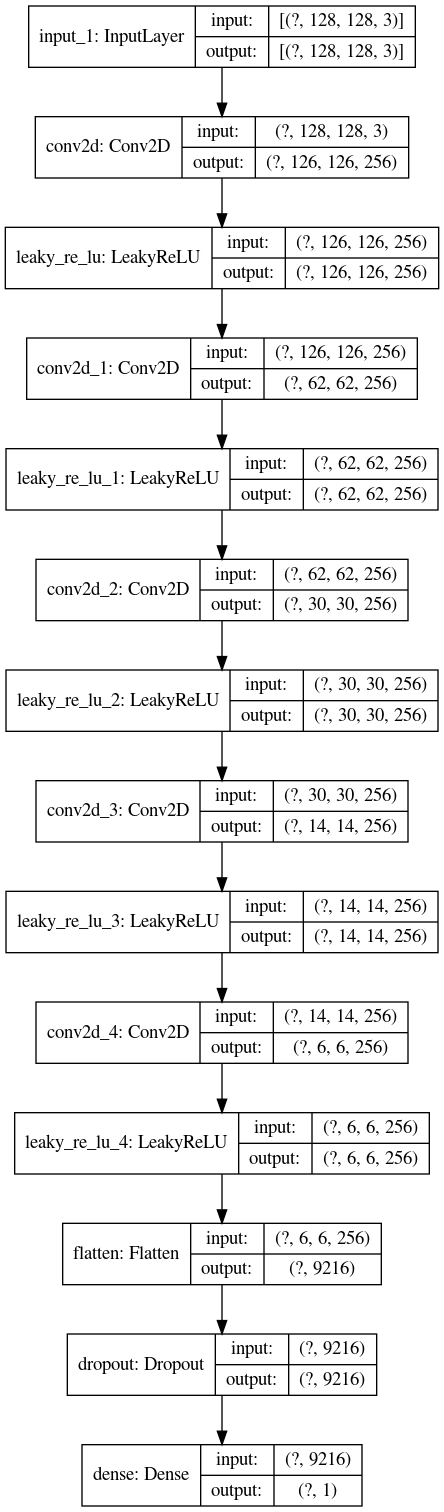

In [ ]:
discriminator = create_discriminator() # Define model

discriminator.trainable = False # Freeze the discriminator model

discriminator.summary() # Summarize the model

plot_model(discriminator, to_file='discriminator_plot.png',
           show_shapes=True,
           show_layer_names=True) # Plot the model

**Break down this discriminator architecture layer by layer:**

**1. `input_1: InputLayer`**

   - **Point:** Defines the input shape for the discriminator.
   - **Details:** Expects images of size 128x128 with 3 color channels (likely RGB). The `?` indicates a variable batch size.

**2. `conv2d: Conv2D`**

   - **Point:** First convolutional layer extracts initial features.
   - **Details:** Applies 256 filters of size 3x3 to the input image. Output feature maps are 126x126 due to valid padding (no padding).

**3. `leaky_re_lu: LeakyReLU`**

   - **Point:** Applies LeakyReLU activation for non-linearity.
   - **Details:** Introduces non-linearity to the feature maps, allowing the network to learn complex patterns.

**4. `conv2d_1: Conv2D`**

   - **Point:** Second convolutional layer extracts more features and downsamples.
   - **Details:** Applies 256 filters of size 4x4 with a stride of 2, reducing the spatial dimensions to 62x62.

**5. `leaky_re_lu_1: LeakyReLU`**

   - **Point:** Applies LeakyReLU activation.
   - **Details:** Non-linearity after the second convolutional layer.

**6. `conv2d_2: Conv2D`**

   - **Point:** Further feature extraction and downsampling.
   - **Details:** Applies 256 filters of size 4x4 with stride 2, reducing dimensions to 30x30.

**7. `leaky_re_lu_2: LeakyReLU`**

   - **Point:** Applies LeakyReLU activation.
   - **Details:** Non-linearity.

**8. `conv2d_3: Conv2D`**

   - **Point:** More feature extraction and downsampling.
   - **Details:** Applies 256 filters of size 4x4 with stride 2, reducing dimensions to 14x14.

**9. `leaky_re_lu_3: LeakyReLU`**

   - **Point:** Applies LeakyReLU activation.
   - **Details:** Non-linearity.

**10. `conv2d_4: Conv2D`**

   - **Point:** Final convolutional layer for feature extraction.
   - **Details:** Applies 256 filters of size 4x4 with stride 2, reducing dimensions to 6x6.

**11. `leaky_re_lu_4: LeakyReLU`**

   - **Point:** Applies LeakyReLU activation.
   - **Details:** Non-linearity.

**12. `flatten: Flatten`**

   - **Point:** Flattens the feature maps into a 1D vector.
   - **Details:** Converts the 6x6x256 feature maps into a 9216-element vector, preparing for the dense layer.

**13. `dropout: Dropout`**

   - **Point:** Applies dropout regularization to prevent overfitting.
   - **Details:** Randomly sets a fraction of input units to 0 during training, reducing co-adaptation of neurons.

**14. `dense: Dense`**

   - **Point:** Final dense layer for binary classification.
   - **Details:** Outputs a single value (probability) indicating whether the input image is real or fake. Uses a sigmoid activation function to constrain the output to the range [0, 1].

### **Create a Generator**

The generator goes the other way: It is the artist who is trying to fool the discriminator. This network consists of 8 convolutional layers. Here first, we take our input, called gen_input and feed it into our first convolutional layer. Each convolutional layer performs a convolution and then performs batch normalization and a leaky ReLu as well. Then, we return the tanh activation function.

In [ ]:
latent_dim = 64  # Define the dimension of the latent space (input noise vector)
channels = 3  # Define the number of channels in the generated image (3 for RGB)

def create_generator():
    """
    Creates the generator model for the GAN.
    """
    gen_input = Input(shape=(latent_dim, ))  # Define the input layer for the generator, which takes a latent vector as input

    x = Dense(128 * 16 * 16)(gen_input)  # First dense layer to expand the latent vector into a larger representation
    x = LeakyReLU()(x)  # Apply LeakyReLU activation for non-linearity
    x = Reshape((16, 16, 128))(x)  # Reshape the output to a 3D tensor, starting the image generation process

    x = Conv2D(256, 5, padding='same')(x)  # First convolutional layer for feature extraction
    x = LeakyReLU()(x)  # Apply LeakyReLU activation

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)  # First transposed convolutional layer for upsampling
    x = LeakyReLU()(x)  # Apply LeakyReLU activation

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)  # Second transposed convolutional layer for upsampling
    x = LeakyReLU()(x)  # Apply LeakyReLU activation

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)  # Third transposed convolutional layer for upsampling
    x = LeakyReLU()(x)  # Apply LeakyReLU activation

    x = Conv2D(512, 5, padding='same')(x)  # Convolutional layer
    x = LeakyReLU()(x) # LeakyRelu activation.

    x = Conv2D(512, 5, padding='same')(x) # Convolutional layer
    x = LeakyReLU()(x) # LeakyRelu activation.

    x = Conv2D(channels, 7, activation='tanh', padding='same')(x)  # Output convolutional layer to generate the final image
                                                                    # 'channels' determines the number of color channels (RGB).
                                                                    # 'tanh' activation scales pixel values to [-1, 1].
                                                                    # 'padding='same'' ensures the output has the same spatial dimensions as the input.

    generator = Model(gen_input, x)  # Create the generator model using the input and output tensors
    return generator  # Return the created generator model

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             2129920   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)      

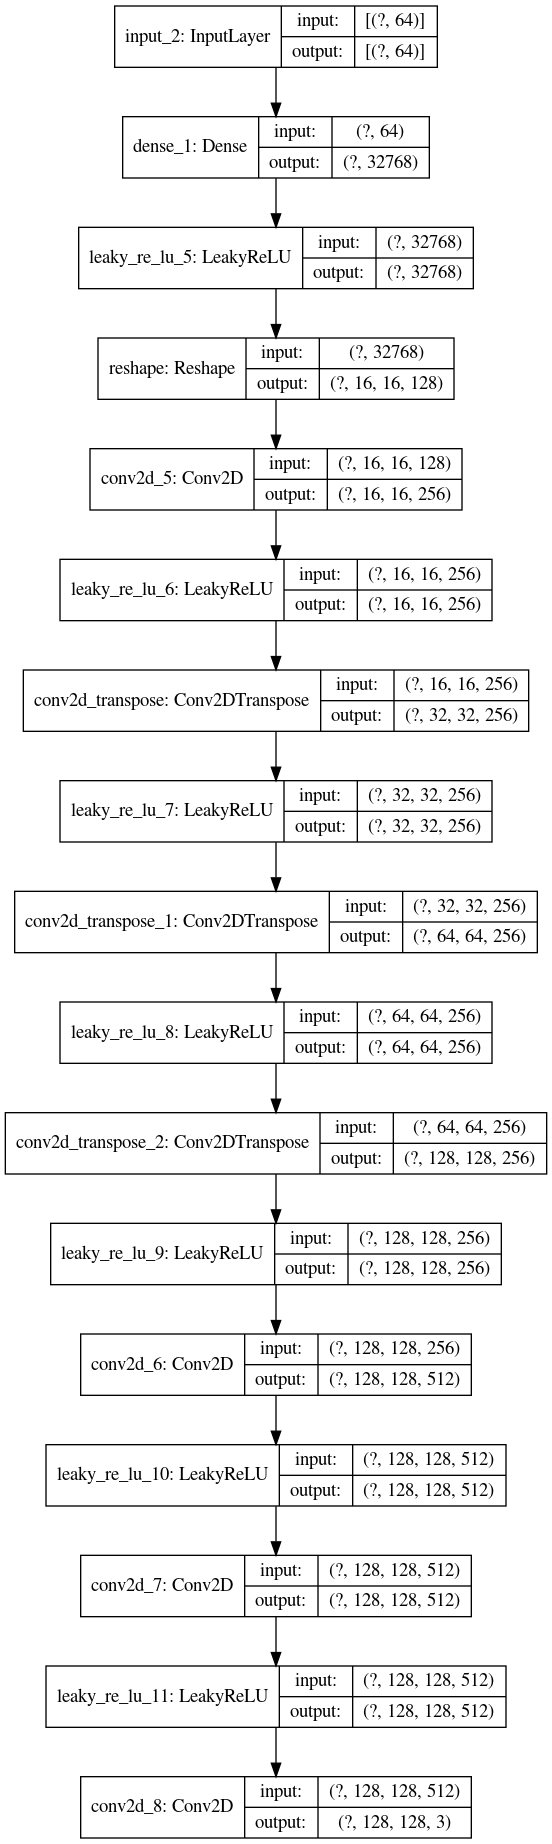

In [ ]:
# define the generator model
generator = create_generator()

# summarize the model
generator.summary()

# plot the model
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

**Break down Generator architecture layer by layer:**

**1. `input_2: InputLayer`**

   - **Point:** Defines the input shape for the generator.
   - **Details:** Expects a latent vector (random noise) of size 64. The `?` indicates a variable batch size.

**2. `dense_1: Dense`**

   - **Point:** First dense layer expands the latent vector.
   - **Details:** Transforms the 64-dimensional input into a 32768-dimensional vector, providing a larger representation for image generation.

**3. `leaky_re_lu_5: LeakyReLU`**

   - **Point:** Applies LeakyReLU activation.
   - **Details:** Introduces non-linearity to the dense output.

**4. `reshape: Reshape`**

   - **Point:** Reshapes the dense output into a 3D tensor.
   - **Details:** Transforms the 32768-element vector into a 16x16x128 tensor, starting the image formation process.

**5. `conv2d_5: Conv2D`**

   - **Point:** First convolutional layer for feature extraction.
   - **Details:** Applies 256 filters of size 3x3 to the reshaped tensor.

**6. `leaky_re_lu_6: LeakyReLU`**

   - **Point:** Applies LeakyReLU activation.
   - **Details:** Non-linearity.

**7. `conv2d_transpose_1: Conv2DTranspose`**

   - **Point:** First transposed convolutional layer for upsampling.
   - **Details:** Upsamples the feature maps to 32x32 using 256 filters of size 4x4 and stride 2.

**8. `leaky_re_lu_7: LeakyReLU`**

   - **Point:** Applies LeakyReLU activation.
   - **Details:** Non-linearity.

**9. `conv2d_transpose_1_1: Conv2DTranspose`**

   - **Point:** Second transposed convolutional layer for upsampling.
   - **Details:** Upsamples the feature maps to 64x64 using 256 filters of size 4x4 and stride 2.

**10. `leaky_re_lu_8: LeakyReLU`**

   - **Point:** Applies LeakyReLU activation.
   - **Details:** Non-linearity.

**11. `conv2d_transpose_2: Conv2DTranspose`**

   - **Point:** Third transposed convolutional layer for upsampling.
   - **Details:** Upsamples the feature maps to 128x128 using 256 filters of size 4x4 and stride 2.

**12. `leaky_re_lu_9: LeakyReLU`**

   - **Point:** Applies LeakyReLU activation.
   - **Details:** Non-linearity.

**13. `conv2d_6: Conv2D`**

   - **Point:** Convolutional layer for feature extraction.
   - **Details:** Applies 512 filters of size 3x3.

**14. `leaky_re_lu_10: LeakyReLU`**

   - **Point:** Applies LeakyReLU activation.
   - **Details:** Non-linearity.

**15. `conv2d_7: Conv2D`**

   - **Point:** Convolutional layer for feature extraction.
   - **Details:** Applies 512 filters of size 3x3.

**16. `leaky_re_lu_11: LeakyReLU`**

   - **Point:** Applies LeakyReLU activation.
   - **Details:** Non-linearity.

**17. `conv2d_8: Conv2D`**

   - **Point:** Final convolutional layer to generate the image.
   - **Details:** Applies 3 filters (for RGB) of size 3x3 to produce the final 128x128 image with 3 color channels. Uses a `tanh` activation (implied, not shown) to scale pixel values to the range [-1, 1].

### **Define a GAN Model**

Next, a GAN model can be defined that combines both the generator model and the discriminator model into one larger model. This larger model will be used to train the model weights in the generator, using the output and error calculated by the discriminator model. The discriminator model is trained separately, and as such, the model weights are marked as not trainable in this larger GAN model to ensure that only the weights of the generator model are updated. This change to the trainability of the discriminator weights only affects when training the combined GAN model, not when training the discriminator standalone.

This larger GAN model takes as input a point in the latent space, uses the generator model to generate an image, which is fed as input to the discriminator model, then output or classified as real or fake.

In [ ]:
gan_input = Input(shape=(latent_dim, ))  # Define the input layer for the GAN, with shape (latent_dim,).
                                        # This input will be the latent vector (random noise) that the generator uses.

gan_output = discriminator(generator(gan_input)) # Connect the generator and discriminator models.
                                                # 1. 'generator(gan_input)' passes the latent vector through the generator, producing a generated image.
                                                # 2. 'discriminator(...)' then passes the generated image through the discriminator, producing a probability (or classification) of whether the image is real or fake.

gan = Model(gan_input, gan_output) # Create the full GAN model.
                                    # The input to the GAN is the latent vector (gan_input).
                                    # The output of the GAN is the discriminator's classification of the generated image (gan_output).
                                    # This effectively combines the generator and discriminator into a single model for training the generator.

In [ ]:
# RMSProp as an optimizer generates more realistic fake images compared to Adam for this case
optimizer = RMSprop(lr=.0001,  # Initialize the RMSprop optimizer with a learning rate of 0.0001
                    clipvalue=1.0,  # Set the clipvalue to 1.0 to prevent exploding gradients
                    decay=1e-8)  # Set the decay rate to 1e-8 for learning rate decay

# GANs try to replicate a probability distribution. So, we used loss functions that reflect the distance between the distribution of the data generated by the GAN and the distribution of the real data
gan.compile(optimizer=optimizer,  # Compile the GAN model with the RMSprop optimizer
            loss='binary_crossentropy')  # Compile the GAN model with binary cross-entropy loss

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
functional_3 (Functional)    (None, 128, 128, 3)       16002563  
_________________________________________________________________
functional_1 (Functional)    (None, 1)                 4211713   
Total params: 20,214,276
Trainable params: 16,002,563
Non-trainable params: 4,211,713
_________________________________________________________________


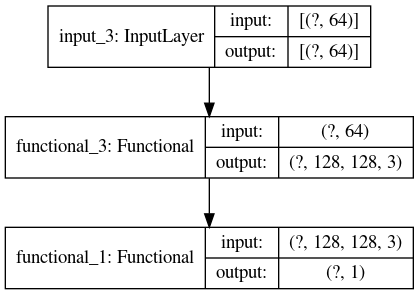

In [ ]:
gan.summary()

# plot gan model
plot_model(gan, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

## **Model Training**

### **Training the GAN model:**


Training is the hardest part and since a GAN contains two separately trained networks, its training algorithm must address two complications:

GANs must juggle two different kinds of training (generator and discriminator).

GAN convergence is hard to identify.

As the generator improves with training, the discriminator performance gets worse because the discriminator can’t easily tell the difference between real and fake. If the generator succeeds perfectly, then the discriminator has a 50% accuracy. In effect, the discriminator flips a coin to make its prediction.


This progression poses a problem for convergence of the GAN as a whole: the discriminator feedback gets less meaningful over time. If the GAN continues training past the point when the discriminator is giving completely random feedback, then the generator starts to train on junk feedback, and its quality may collapse.

In [ ]:
import time

In [ ]:
def summary_report(step, iters, d_loss, g_loss, start_time, generator, control_vectors, WIDTH, HEIGHT, channels, img_size_sqrt):
    """
    Prints progress information and displays a control image grid.
    """
    elapsed = time.time() - start_time  # Calculate the elapsed time for the current iteration
    print(f"{step+1}/{iters}: d_loss: {d_loss:.4f}, g_loss: {g_loss:.4f} ({elapsed:.1f} sec)")  # Print the progress report including iteration number, losses, and elapsed time

    # Build a grid of control images
    control_image = np.zeros((WIDTH * img_size_sqrt, HEIGHT * img_size_sqrt, channels))  # Initialize an empty array for the control image grid
    control_generated = generator.predict(control_vectors)  # Generate images using the generator and the control latent vectors
    for i in range(img_size_sqrt ** 2):  # Iterate through the grid positions
        # Using the same indexing as your original code
        x_off = i % img_size_sqrt  # Calculate the x offset for the current image in the grid
        y_off = i // img_size_sqrt  # Calculate the y offset for the current image in the grid
        control_image[x_off * WIDTH:(x_off + 1) * WIDTH,  # Place the generated image into the correct position in the grid
                      y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i]

    plt.figure(figsize=(img_size_sqrt, img_size_sqrt))  # Create a figure with the specified size
    plt.imshow(np.uint8(control_image * 255))  # Display the control image grid, scaled to 0-255 and converted to uint8
    plt.axis('off')  # Turn off the axis labels and ticks
    plt.show()  # Display the plot

In [ ]:
def save_plot(examples, step, n=6):
    """
    Creates and saves a grid plot of generated images to the 'GAN_images' folder.

    Parameters:
        - examples (numpy.array): Array of images in the range [-1, 1] with shape (n*n, width, height, channels).
        - step (int): Current training iteration, used to construct the filename.
        - n (int): Grid dimensions; defaults to 6 (i.e., an n x n grid).

    The function scales the images to the [0, 1] range, arranges them in a grid and saves the plot to disk.
    """

    # Scale images from [-1, 1] to [0, 1]
    examples = (examples + 1) / 2.0  # Scale the pixel values to the range [0, 1]

    # Create a figure with a grid of subplots
    fig, axs = plt.subplots(n, n, figsize=(15, 15))  # Create a figure and an array of subplots

    # Flatten the axis array for easier iteration
    axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array

    # Loop over the subplots and display each image
    for i in range(n * n):  # Iterate through the images
        axs[i].imshow(examples[i], interpolation='nearest')  # Display the image in the subplot
        axs[i].axis('off')  # Turn off the axis for a clean look

    # Adjust layout with minimal padding
    fig.tight_layout(pad=0)  # Adjust the subplot layout to minimize padding

    # Define the target folder and create it if it doesn't exist
    folder = "GAN_images"  # Define the folder name
    if not os.path.exists(folder):  # Check if the folder exists
        os.makedirs(folder)  # Create the folder if it doesn't exist

    # Build the filename using the iteration count (step) and the folder path
    filename = os.path.join(folder, 'generated_plot_{:05d}.png'.format(step + 1))  # Create the filename

    # Save the figure and close it to free resources
    fig.savefig(filename, bbox_inches='tight', pad_inches=0)  # Save the figure to disk
    plt.close(fig)  # Close the figure to free memory

    # Confirmation output
    print("Saved plot to", filename)  # Print a confirmation message

In [ ]:
def save_model(model, step):
    """
    Saves the given Keras model to disk in HDF5 format in the 'generator_model' folder.

    Parameters:
      - model: A Keras model instance (generator, discriminator, or full GAN).
      - step (int): The current training iteration number.
    """
    # Define the folder name
    folder = "generator_model"

    # Ensure the folder exists, and if not, create it
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Construct the full file path by joining the folder and filename
    filename = os.path.join(folder, f"generator_model_{step+1:05d}.h5")

    # Save the complete model (architecture and weights)
    model.save(filename)

    # Confirmation output
    print(f"Saved model to '{filename}'")

In [ ]:
def train(generator, discriminator, gan, images, latent_dim=64, iters=32000, batch_size=16):
    """
    Main training loop.

    Expects:
        - generator, discriminator, gan: pre-built Keras models.
        - images: numpy array of real images with shape (num_images, WIDTH, HEIGHT, channels)
        - latent_dim: dimension of the latent space.
        - iters: total number of training iterations.
        - batch_size: batch size used for training.

    The function calls:
        - summary_report() every 50 iterations,
        - save_plot() every 100 iterations (to view a grid of generated images), and
        - save_model() every 2000 iterations.
    """
    img_size_sqrt = 6  # Define the square root of the number of control images for visualization
    # Prepare control latent vectors for consistent visualization
    control_vectors = np.random.normal(size=(img_size_sqrt ** 2, latent_dim)) / 2  # Generate fixed latent vectors for visualization

    # Lists for tracking losses (optional)
    d_losses = []  # List to store discriminator losses
    g_losses = []  # List to store generator losses

    # Extract data dimensions (images are assumed to have shape: (num_images, WIDTH, HEIGHT, channels))
    WIDTH, HEIGHT, channels = images.shape[1], images.shape[2], images.shape[3]  # Extract image dimensions

    start = 0  # Initialize the starting index for image batches
    for step in range(iters):  # Iterate through the training steps
        start_time = time.time()  # Record the start time of the step

        # Generate fake images from random latent vectors
        latent_vectors = np.random.normal(size=(batch_size, latent_dim))  # Generate random latent vectors
        generated = generator.predict(latent_vectors)  # Generate fake images using the generator

        # Select a batch of real images from your dataset
        real = images[start:start + batch_size]  # Select a batch of real images
        combined_images = np.concatenate([generated, real])  # Combine fake and real images

        # Create labels for generated (1) and real (0) images,
        # adding a bit of random noise to smooth the labels.
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])  # Create labels for real and fake images
        labels += 0.05 * np.random.random(labels.shape)  # Add random noise to the labels

        # Update the discriminator on the combined images
        d_loss = discriminator.train_on_batch(combined_images, labels)  # Train the discriminator
        d_losses.append(d_loss)  # Append discriminator loss to the list

        # Train the generator (via the GAN model) to produce images
        # that the discriminator classifies as real (i.e. 0)
        latent_vectors = np.random.normal(size=(batch_size, latent_dim))  # Generate random latent vectors
        misleading_targets = np.zeros((batch_size, 1))  # Create misleading targets (all 0s)
        g_loss = gan.train_on_batch(latent_vectors, misleading_targets)  # Train the generator
        g_losses.append(g_loss)  # Append generator loss to the list

        start += batch_size  # Increment the starting index
        if start > images.shape[0] - batch_size:  # Reset the starting index if it exceeds the number of images
            start = 0

        # Every 50 iterations, print summary and display the control grid
        if (step + 1) % 50 == 0:
            summary_report(step, iters, d_loss, g_loss, start_time, generator, control_vectors, WIDTH, HEIGHT, channels, img_size_sqrt) # print training summary and display generated images

        # Generate and save plot of images every 100 iterations
        if (step + 1) % 100 == 0:
            # Generate a consistent set of example images from the control vectors.
            examples = generator.predict(control_vectors) # generate images using the fixed latent vectors.
            save_plot(examples, step, n=img_size_sqrt) # save the generated images in a grid.

        # Save the generator model after every 2000 iterations
        if (step + 1) % 2000 == 0:
            save_model(generator, step) # save the generator model.

**Break down the `train` function for a Generative Adversarial Network (GAN):**

**1. `def train(...)`:**

   - **Point:** Defines the training function for the GAN.
   - **Details:** Takes as input the generator, discriminator, combined GAN model, real images, latent dimension, training iterations, and batch size.

**2. `img_size_sqrt = 6`:**

   - **Point:** Sets the grid size for visualization.
   - **Details:** Determines the number of images to display in the control grid (6x6 = 36 images).

**3. `control_vectors = ...`:**

   - **Point:** Generates fixed latent vectors for visualization.
   - **Details:** Creates a set of constant noise vectors used to generate consistent images for monitoring training progress.

**4. `d_losses = []`, `g_losses = []`:**

   - **Point:** Initializes lists to store losses.
   - **Details:** Used to track the discriminator and generator losses during training (optional).

**5. `WIDTH, HEIGHT, channels = ...`:**

   - **Point:** Extracts image dimensions.
   - **Details:** Obtains the width, height, and number of channels from the real images array.

**6. `start = 0`:**

   - **Point:** Initializes image batch start index.
   - **Details:** Tracks the starting position for selecting batches of real images.

**7. `for step in range(iters):`:**

   - **Point:** Main training loop.
   - **Details:** Iterates through the specified number of training steps (`iters`).

**8. `start_time = time.time()`:**

   - **Point:** Records the start time.
   - **Details:** Used to measure the time taken for each training step.

**9. `latent_vectors = ...`, `generated = ...`:**

   - **Point:** Generates fake images.
   - **Details:** Creates random noise vectors and uses the generator to produce fake images.

**10. `real = ...`, `combined_images = ...`:**

   - **Point:** Selects real images and combines them with generated images.
   - **Details:** Retrieves a batch of real images and concatenates them with the generated images for discriminator training.

**11. `labels = ...`, `labels += ...`:**

   - **Point:** Creates labels for real and fake images.
   - **Details:** Assigns labels (1 for real, 0 for fake) and adds random noise to smooth the labels, improving training stability.

**12. `d_loss = ...`, `d_losses.append(...)`:**

   - **Point:** Trains the discriminator.
   - **Details:** Updates the discriminator's weights using the combined images and labels, and records the loss.

**13. `latent_vectors = ...`, `misleading_targets = ...`, `g_loss = ...`, `g_losses.append(...)`:**

   - **Point:** Trains the generator.
   - **Details:** Generates new random noise, creates "misleading" labels (all 0s), and updates the generator's weights through the combined GAN model, recording the generator loss.

**14. `start += batch_size`, `if start > ...`:**

   - **Point:** Updates batch index and resets if needed.
   - **Details:** Increments the starting position for the next batch and resets it if it exceeds the available images.

50/32000: d_loss: 0.6177, g_loss: 0.9170 (0.9 sec)


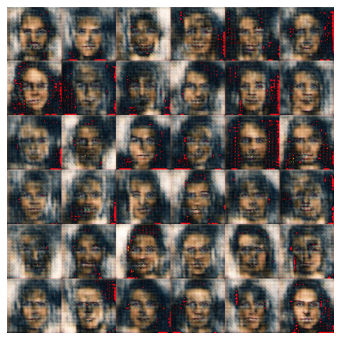

100/32000: d_loss: 0.6981, g_loss: 1.6463 (0.9 sec)


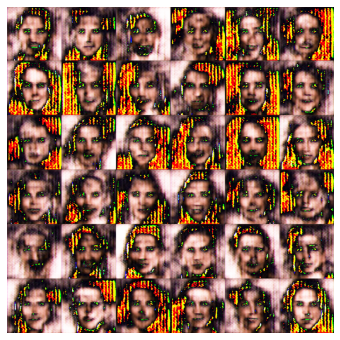

Saved plot to GAN_images/generated_plot_00100.png
150/32000: d_loss: 0.6435, g_loss: 1.1150 (0.9 sec)


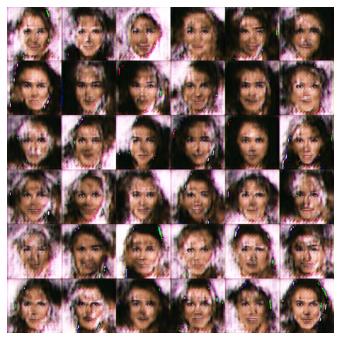

200/32000: d_loss: 0.7077, g_loss: 0.7486 (0.9 sec)


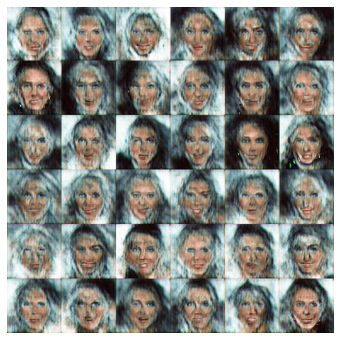

Saved plot to GAN_images/generated_plot_00200.png
250/32000: d_loss: 0.6958, g_loss: 1.9535 (0.9 sec)


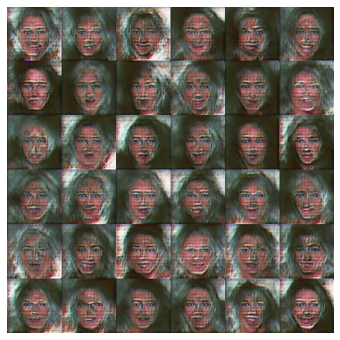

300/32000: d_loss: 0.6467, g_loss: 1.0359 (0.9 sec)


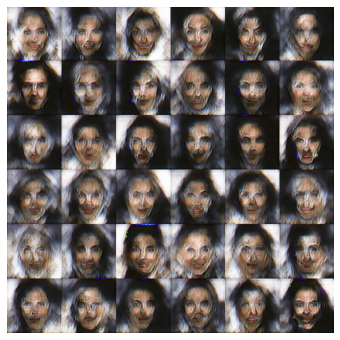

Saved plot to GAN_images/generated_plot_00300.png
350/32000: d_loss: 0.8881, g_loss: 0.7661 (0.9 sec)


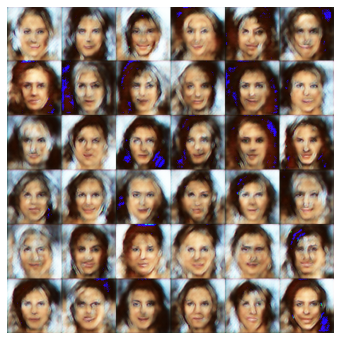

400/32000: d_loss: 0.6114, g_loss: 1.1164 (0.9 sec)


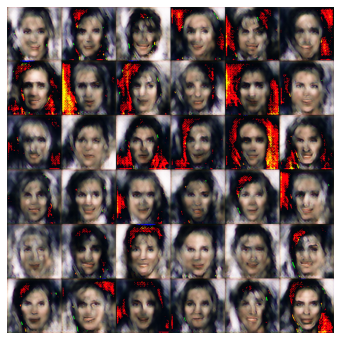

Saved plot to GAN_images/generated_plot_00400.png


KeyboardInterrupt: 

In [ ]:
train(generator, discriminator, gan, images)

## **Testing Generated Images**

In [ ]:
from tensorflow.keras.models import load_model

# Load the generator model
loaded_generator = load_model("/kaggle/working/generator_model/generator_model_16000.h5")

def generate_single_image(generator, latent_dim=64):
    """
    Generates a single image using the provided generator model.

    Parameters:
      - generator: The generator model that outputs images.
      - latent_dim (int): Dimension of the latent space.

    Returns:
      - sample: A generated image scaled to the [0, 1] range.
    """
    # Generate a random latent vector of shape (1, latent_dim)
    latent_vector = np.random.normal(0, 1, (1, latent_dim))

    # Produce an image using the generator
    generated = generator.predict(latent_vector)

    # Expecting output shape of (1, height, width, channels)
    if generated.ndim == 4:
        sample = generated[0]  # Remove the batch dimension.
    else:
        raise ValueError(f"Expected output (1, H, W, C) but got {generated.shape}")

    # The generator uses tanh activation so the output is in [-1, 1]. Scale that to [0, 1].
    sample = (sample + 1) / 2.0
    sample = np.clip(sample, 0, 1)
    return sample

# Generate a single image using the loaded generator
image = generate_single_image(loaded_generator, latent_dim=64)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')
plt.title("Generated Image from Loaded Generator")
plt.show()

### **Downloading Outputs in zip format**

In [ ]:
import shutil

# Define the folder with your images
folder_path = '/kaggle/working/GAN_images'

# Set the output file name (without extension)
output_filename = 'GAN_images_archive'

# Create a ZIP archive of the folder
shutil.make_archive(output_filename, 'zip', folder_path)

print(f"Created {output_filename}.zip. You can now download it from the output files.")

In [ ]:
import shutil

# Define the folder with your images
folder_path = '/kaggle/working/generator_model'

# Set the output file name (without extension)
output_filename = 'GAN_model_archive'

# Create a ZIP archive of the folder
shutil.make_archive(output_filename, 'zip', folder_path)

print(f"Created {output_filename}.zip. You can now download it from the output files.")